In [1]:
# pip install matplotlib==3.6.0 --force-reinstall

In [24]:
#import libraries
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report, roc_curve, auc, log_loss, f1_score, mean_absolute_error, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif
from imblearn.metrics import specificity_score
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from tabulate import tabulate
import pickle

**Phase 1 steps required to continue with the Phase 2**

In [3]:
#read the multiple files 
Telco_customer_demographics = pd.read_csv('Telco_customer_churn_demographics.csv')
Telco_customer_services = pd.read_csv('Telco_customer_churn_services_1.csv')
Telco_customer_population = pd.read_csv('Telco_customer_churn_population.csv')
Telco_customer_status = pd.read_csv('Telco_customer_churn_status.csv')
Telco_customer_location = pd.read_csv('Telco_customer_churn_location.csv')
Telco_customer = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

#merge the data
#merging location and population on zip code as it is the primary key for the population data.
df_loc_pop = pd.merge(left = Telco_customer_location, right = Telco_customer_population, how = 'inner' ,
                      on = 'Zip Code')

#merging other files on customer id as it is the primary key for the population data.
df_dem_ser = pd.merge(left = Telco_customer_demographics, right = Telco_customer_services, how = 'outer' ,
                      on = 'Customer ID')
df_sta_loc_pop = pd.merge(left = Telco_customer_status, right = df_loc_pop, how = 'inner' ,on = 'Customer ID')
df_all = pd.merge(left = df_dem_ser, right = df_sta_loc_pop, how = 'inner' ,on = 'Customer ID')
df = pd.merge(left = df_all, right = Telco_customer, how = 'inner' ,on = 'Customer ID')

#Remove Duplicate columns
df = df.drop(['Count_x_y', 'Count_y_x', 'Count_y_y', 'Phone Service_y','Payment Method_x','Quarter_y','tenure',
              'Tota lCharges','Senior Citizen_y','Dependents_y','Multiple Lines_x','Internet Service_y',
              'Online Security_y','Online Backup_y','Streaming TV_y','Streaming Movies_y','Contract_y', 'gender',
              'Paperless Billing_x','Lat Long','Monthly Charges'], axis = 1)

#Rename columns
df = df.rename(columns=
               {'Customer ID':'customer_id',
                'Married':'married',
                'Referred a Friend':'referred_a_friend',
                'Phone Service_x':'phone_service',
                'Avg Monthly GB Download':'avg_monthly_gb_download',
                'Premium Tech Support':'premium_tech_support',
                'Contract_x':'contract',
                'Total Extra Data Charges':'total_extra_data_charges',
                'Total Revenue':'total_revenue',
                'Churn Value':'churn_value',
                'Country':'country',
                'Longitude':'longitude',
                'Multiple Lines_y':'multiple_lines',
                'Online Backup_x':'online_backup',
                'Streaming TV_x':'streaming_tv',
                'Payment Method_y':'payment_method',
                'Count_x_x':'count',
                'Dependents_x':'dependents',
                'Number of Referrals':'number_of_referrals',
                'Avg Monthly Long Distance Charges':'avg_monthly_long_distance_charges',
                'Device Protection Plan':'device_protection_plan',
                'Streaming Music':'streaming_music',
                'Monthly Charge':'monthly_charge',
                'Total Long Distance Charges':'total_long_distance_charges',
                'Satisfaction Score':'satisfaction_score',
                'Churn Score':'churn_score',
                'State':'state',
                'ID':'id',
                'Internet Service_x':'internet_service',
                'Device Protection':'device_protection',
                'Streaming Movies_x':'streaming_movies',
                'Gender':'female',
                'Number of Dependents':'number_of_dependents',
                'Tenure in Months':'tenure_in_months',
                'Internet Type':'internet_type',
                'Unlimited Data':'unlimited_data',
                'Total Charges':'total_charges',
                'Customer Status':'customer_status',
                'CLTV':'cltv',
                'City':'city',
                'Population':'population',
                'Online Security_x':'online_security',
                'Tech Support':'tech_support',
                'Paperless Billing_y':'paperless_billing',
                'Age':'age',
                'Quarter_x':'quarter',
                'Offer':'offer',
                'Total Refunds':'total_refunds',
                'Churn Label':'churn_label',
                'Churn Category':'churn_category',
                'Zip Code':'zip_code',
                'Churn Reason':'churn_reason',
                'Lat Long':'lat_long',
                'Partner':'partner',
                'Under 30':'under_30',
                'Senior Citizen_x':'senior_citizen',
                'Latitude':'latitude',
                'Churn':'churn'
               })

#Dropping redundant columns that are not required 
df = df.drop(['customer_id','country','state','latitude','longitude','quarter','count',
              'offer','zip_code','device_protection','tech_support','population','city',
             'churn_score','churn','churn_value','id','partner','customer_status','churn_category', 'churn_reason'],axis=1)
df.drop(labels=df[df['tenure_in_months'] == 0].index, axis=0, inplace=True)
df["total_charges"].fillna(value = df["total_charges"].mean(), inplace = True)
df.dropna(axis = 0, inplace = True)
df = df.applymap(lambda x: 0 if x == 'No' else 1 if x == 'Yes' else x  if isinstance(x, str) else x)
df['female']= df['female'].map({'Male' : 0 , 'Female' : 1})
df['grouped_tenure'] = df.apply(lambda df: 
                                "less_than_1"
                                if df.tenure_in_months <= 12
                                else "less_than_2"
                                if df.tenure_in_months <= 24
                                else "less_than_3"
                                if df.tenure_in_months <= 36
                                else "less_than_4"
                                if df.tenure_in_months <= 48
                                else "less_than_5"
                                if df.tenure_in_months <= 60
                                else "greater_than_5", 
                                axis = 1)

temp = df['payment_method']
df = df.drop(['payment_method', 'grouped_tenure', 'internet_type', 'multiple_lines', 'contract'], axis = 1)

#Converting object data types into int64 for correlation matrix
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).astype('int64')
df['payment_method'] = temp

df = df.drop(['total_extra_data_charges','streaming_music',
             'streaming_movies','total_refunds','device_protection_plan','streaming_tv', 'online_backup',
             'avg_monthly_long_distance_charges','under_30','senior_citizen','referred_a_friend',
             'number_of_dependents','avg_monthly_gb_download','phone_service','total_revenue'], axis = 1)

df_payment_method_one_hot = pd.get_dummies(df.payment_method)
df_payment_method_one_hot = df_payment_method_one_hot.drop('Bank transfer (automatic)', axis = 1)
df = df.drop(['payment_method'], axis = 1)

df_payment_method_one_hot = df_payment_method_one_hot.rename(columns=
                                                             {'Credit card (automatic)':'credit_card',
                                                              'Electronic check':'electronic_check',
                                                              'Mailed check' : 'mailed_check'}
                                                            )
df = pd.concat([df,df_payment_method_one_hot], axis = 1)

#applying smote
sm = SMOTE(random_state=42)
X = df.drop(['churn_label'],axis = 1)
Y = df['churn_label']
X, Y = sm.fit_resample(X, Y)
df = pd.concat([X,Y], axis = 1)

#applying min max scaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

**Phase 2:**





In [4]:
X = df.drop(["churn_label"], axis = 1)
Y = df["churn_label"]

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.30, random_state = 40, stratify=Y)

In [5]:
parameters = defaultdict(dict)
best_parameters = defaultdict(dict)
best_score = defaultdict(float)
prediction = defaultdict(list)
probs = defaultdict(list)
best_model = defaultdict()

parameters['SVC'] = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['auto', 'scale']
}

parameters['KNN'] = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

parameters['RF'] = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

parameters['ADAB'] = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

parameters['XGB'] = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [6, 8],
    'n_estimators': [100, 300],
    'colsample_bytree': [0.3, 0.7]
}

parameters['NB'] = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}


models = {
    'SVC' : SVC(),
    'KNN' : KNeighborsClassifier(),
    'RF' : RandomForestClassifier(),
    'ADAB' : AdaBoostClassifier(),
    'XGB' : XGBClassifier(),
    'NB' : GaussianNB()
}



In [6]:
metrics = pd.DataFrame(columns=['Accuracy','Precision', 'Recall', 'Specificity', 'F1 Score', 'MAE', 'Log Loss', 'AUC', 'Train-Test'])

In [7]:
# models

In [8]:
# parameters

In [9]:
for model in models:
  # Create GridSearchCV object
  clf = GridSearchCV(models[model], parameters[model], cv=5)

  # Fit the GridSearchCV object to the data
  clf.fit(X_train, y_train)

  # Prediction based on test dataset
  predicted_y = clf.predict(X_test)

  # Saving the best model
  best_model[model] = clf

  # Probability to calculate FPR, TPR
  if model == 'SVC':
    prob = clf.decision_function(X_test)
    prob = prob[:]
  else:
    prob = clf.predict_proba(X_test)
    prob = prob[:, 1]

  best_parameters[model] = clf.best_params_
  best_score[model] = round(clf.best_score_, 4)
  prediction[model] = predicted_y
  probs[model] = prob


In [10]:
# best_parameters

In [12]:
# best_score

In [28]:
with open("knn.pkl", "wb") as f:
    pickle.dump(best_model['KNN'], f)

with open("svm.pkl", "wb") as f:
    pickle.dump(best_model['SVC'], f)

with open("rf.pkl", "wb") as f:
    pickle.dump(best_model['RF'], f)

with open("xgb.pkl", "wb") as f:
    pickle.dump(best_model['KNN'], f)

with open("nb.pkl", "wb") as f:
    pickle.dump(best_model['NB'], f)

with open("adb.pkl", "wb") as f:
    pickle.dump(best_model['ADAB'], f)

**K Nearest Neighbor**

K Nearest Neighbor Classification Report

               precision    recall  f1-score   support

           0       0.86      0.66      0.75      1548
           1       0.73      0.90      0.80      1547

    accuracy                           0.78      3095
   macro avg       0.79      0.78      0.78      3095
weighted avg       0.79      0.78      0.78      3095



	Evaluation Metrics

|     | Accuracy   | Precision   | Recall   | Specificity   | F1 Score   |   MAE |   Log Loss |   AUC | Train-Test   |
|-----|------------|-------------|----------|---------------|------------|-------|------------|-------|--------------|
| KNN | 77.87%     | 72.59%      | 89.53%   | 66.21%        | 80.17%     | 0.221 |      7.977 | 0.853 | 70%-30%      |




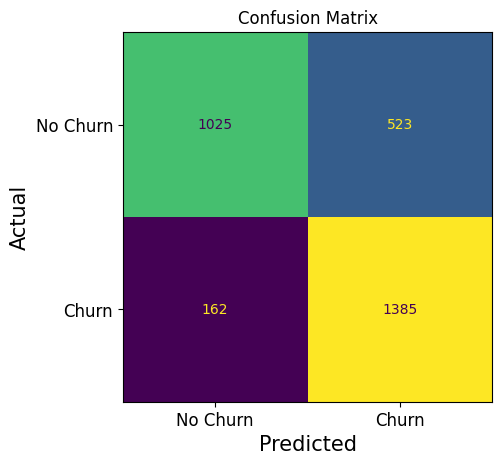

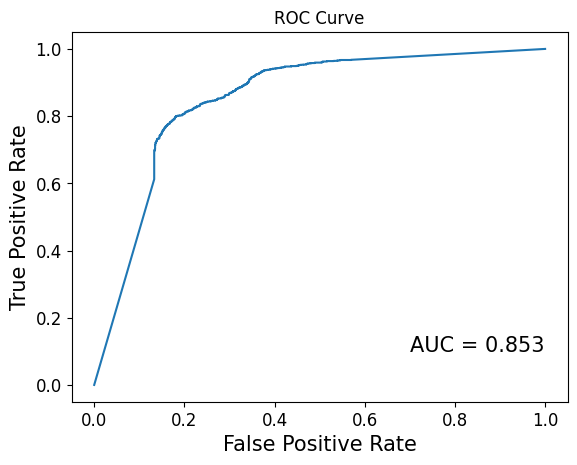

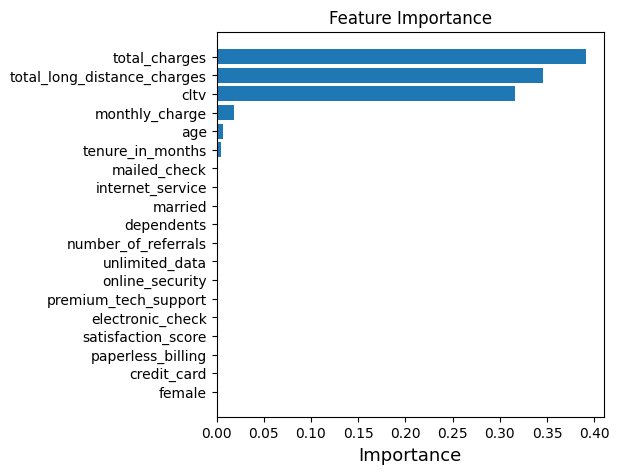

In [14]:
model = best_model['KNN']
predicted_y = model.predict(X_test)
y_scores = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
result = permutation_importance(model, X_train, y_train, n_repeats=1, random_state=42)
result = abs(result.importances_mean)
sorted_idx = result.argsort()
model = 'KNeighborsClassifier'

print("K Nearest Neighbor Classification Report")
print('\n', classification_report(y_test, predicted_y))

metrics.loc['KNN'] = [
                      str(round(accuracy_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(precision_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(recall_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(specificity_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(f1_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(mean_absolute_error(y_test, predicted_y), 3)),
                      str(round(log_loss(y_test, predicted_y), 3)),
                      str(round(roc_auc, 3)),
                      "70%-30%"]

print('\n')
print('\tEvaluation Metrics\n')
print(tabulate(metrics.tail(1), headers = 'keys', tablefmt = 'github'))
print('\n')

cm = confusion_matrix(y_test, predicted_y)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Churn", "Churn"])
cm_display.plot(colorbar = False)
plt.title('Confusion Matrix')
plt.xlabel("Predicted", fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel("Actual", fontsize = 15)
plt.yticks(fontsize = 12)
plt.show()

print('\n')
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.title('ROC Curve')
plt.xlabel("False Positive Rate", fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.yticks(fontsize = 12)
plt.text(0.7, 0.1, f'AUC = {roc_auc:.3f}', fontsize = 15)
plt.show()

print('\n')
fig = plt.figure(figsize = (5, 5))
plt.barh(range(X.shape[1]), result[sorted_idx])
plt.yticks(range(X.shape[1]), X_train.columns[sorted_idx], fontsize = 10)
plt.xticks(fontsize = 10)
plt.xlabel("Importance", fontsize = 13)
plt.title("Feature Importance")
plt.show()

**Support Vector**

Support Vector Classification Report

               precision    recall  f1-score   support

           0       0.74      0.64      0.69      1548
           1       0.68      0.77      0.72      1547

    accuracy                           0.71      3095
   macro avg       0.71      0.71      0.71      3095
weighted avg       0.71      0.71      0.71      3095



	Evaluation Metrics

|     | Accuracy   | Precision   | Recall   | Specificity   | F1 Score   |   MAE |   Log Loss |   AUC | Train-Test   |
|-----|------------|-------------|----------|---------------|------------|-------|------------|-------|--------------|
| SVC | 70.63%     | 68.23%      | 77.18%   | 64.08%        | 72.43%     | 0.294 |     10.586 | 0.796 | 70%-30%      |




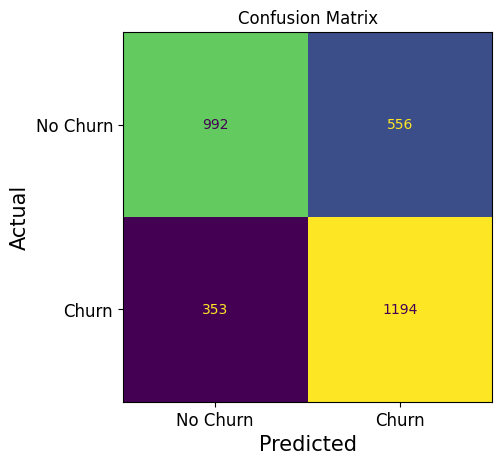

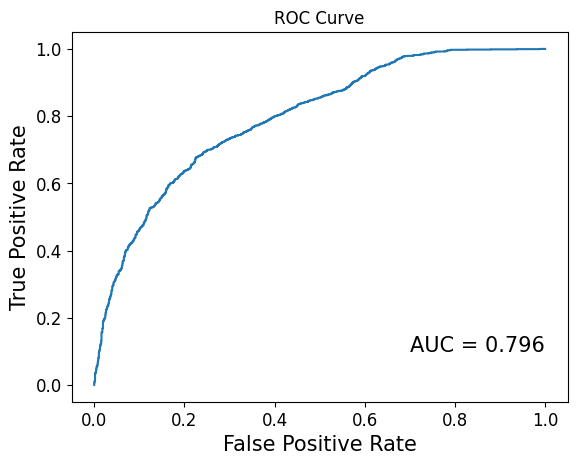

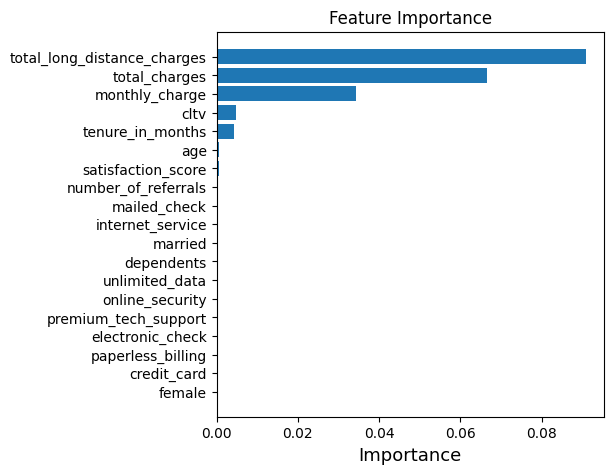

In [15]:
model = best_model['SVC']
predicted_y = model.predict(X_test)
y_scores = model.decision_function(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:])
roc_auc = auc(fpr, tpr)
result = permutation_importance(model, X_train, y_train, n_repeats=1, random_state=42)
result = abs(result.importances_mean)
sorted_idx = result.argsort()
model = 'SVC'

print("Support Vector Classification Report")
print('\n', classification_report(y_test, predicted_y))

metrics.loc['SVC'] = [
                      str(round(accuracy_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(precision_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(recall_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(specificity_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(f1_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(mean_absolute_error(y_test, predicted_y), 3)),
                      str(round(log_loss(y_test, predicted_y), 3)),
                      str(round(roc_auc, 3)),
                      "70%-30%"]

print('\n')
print('\tEvaluation Metrics\n')
print(tabulate(metrics.tail(1), headers = 'keys', tablefmt = 'github'))
print('\n')

cm = confusion_matrix(y_test, predicted_y)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Churn", "Churn"])
cm_display.plot(colorbar = False)
plt.title('Confusion Matrix')
plt.xlabel("Predicted", fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel("Actual", fontsize = 15)
plt.yticks(fontsize = 12)
plt.show()

print('\n')
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.title('ROC Curve')
plt.xlabel("False Positive Rate", fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.yticks(fontsize = 12)
plt.text(0.7, 0.1, f'AUC = {roc_auc:.3f}', fontsize = 15)
plt.show()

print('\n')
fig = plt.figure(figsize = (5, 5))
plt.barh(range(X.shape[1]), result[sorted_idx])
plt.yticks(range(X.shape[1]), X_train.columns[sorted_idx], fontsize = 10)
plt.xticks(fontsize = 10)
plt.xlabel("Importance", fontsize = 13)
plt.title("Feature Importance")
plt.show()

**Naive Bayes**

Naive Bayes Classification Report

               precision    recall  f1-score   support

           0       0.92      0.90      0.91      1548
           1       0.91      0.92      0.91      1547

    accuracy                           0.91      3095
   macro avg       0.91      0.91      0.91      3095
weighted avg       0.91      0.91      0.91      3095



	Evaluation Metrics

|    | Accuracy   | Precision   | Recall   | Specificity   | F1 Score   |   MAE |   Log Loss |   AUC | Train-Test   |
|----|------------|-------------|----------|---------------|------------|-------|------------|-------|--------------|
| NB | 91.41%     | 90.62%      | 92.37%   | 90.44%        | 91.49%     | 0.086 |      3.098 | 0.974 | 70%-30%      |




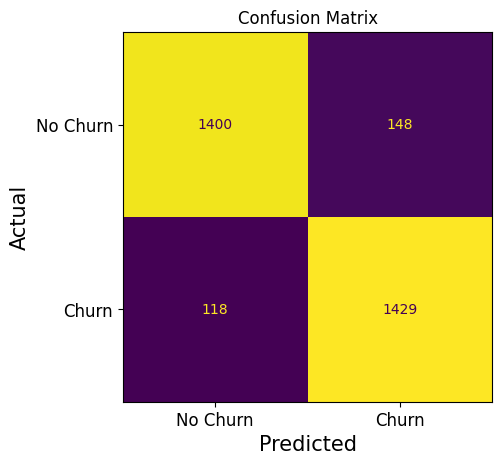

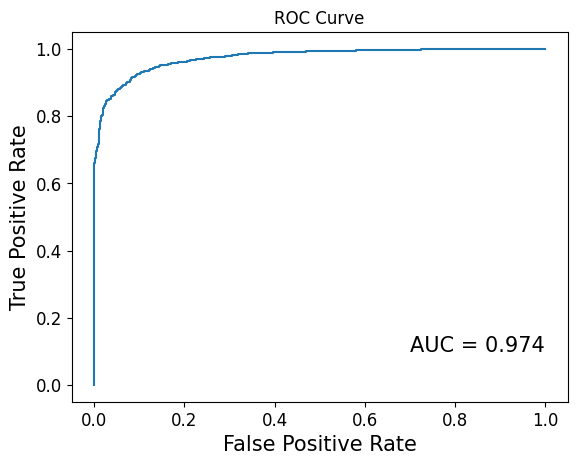

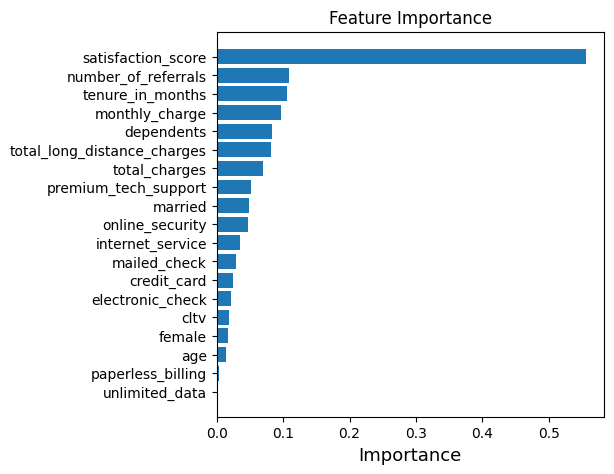

In [16]:
model = best_model['NB']
predicted_y = model.predict(X_test)
y_scores = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
result = abs(mutual_info_classif(X_train, y_train))
sorted_idx = result.argsort()
model = 'GaussianNB'

print("Naive Bayes Classification Report")
print('\n', classification_report(y_test, predicted_y))
metrics.loc['NB'] = [
                      str(round(accuracy_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(precision_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(recall_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(specificity_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(f1_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(mean_absolute_error(y_test, predicted_y), 3)),
                      str(round(log_loss(y_test, predicted_y), 3)),
                      str(round(roc_auc, 3)),
                      "70%-30%"]

print('\n')
print('\tEvaluation Metrics\n')
print(tabulate(metrics.tail(1), headers = 'keys', tablefmt = 'github'))
print('\n')

cm = confusion_matrix(y_test, predicted_y)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Churn", "Churn"])
cm_display.plot(colorbar = False)
plt.title('Confusion Matrix')
plt.xlabel("Predicted", fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel("Actual", fontsize = 15)
plt.yticks(fontsize = 12)
plt.show()

print('\n')
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.title('ROC Curve')
plt.xlabel("False Positive Rate", fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.yticks(fontsize = 12)
plt.text(0.7, 0.1, f'AUC = {roc_auc:.3f}', fontsize = 15)
plt.show()

print('\n')
fig = plt.figure(figsize = (5, 5))
plt.barh(range(X.shape[1]), result[sorted_idx])
plt.yticks(range(X.shape[1]), X_train.columns[sorted_idx], fontsize = 10)
plt.xticks(fontsize = 10)
plt.xlabel("Importance", fontsize = 13)
plt.title("Feature Importance")
plt.show()

**Random Forest**

Random Forest Classification Report

               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1548
           1       0.98      0.95      0.97      1547

    accuracy                           0.97      3095
   macro avg       0.97      0.97      0.97      3095
weighted avg       0.97      0.97      0.97      3095



	Evaluation Metrics

|    | Accuracy   | Precision   | Recall   | Specificity   | F1 Score   |   MAE |   Log Loss |   AUC | Train-Test   |
|----|------------|-------------|----------|---------------|------------|-------|------------|-------|--------------|
| RF | 96.87%     | 98.46%      | 95.22%   | 98.51%        | 96.81%     | 0.031 |       1.13 | 0.997 | 70%-30%      |




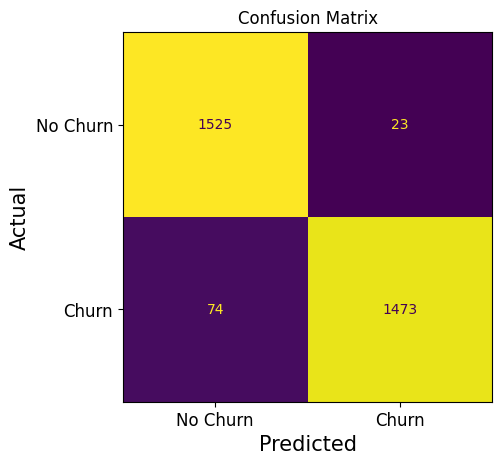

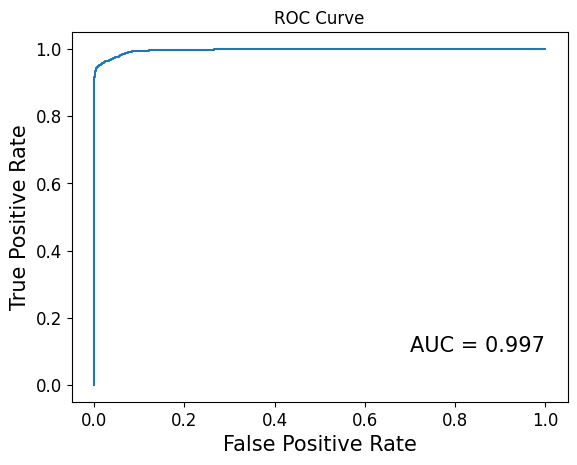

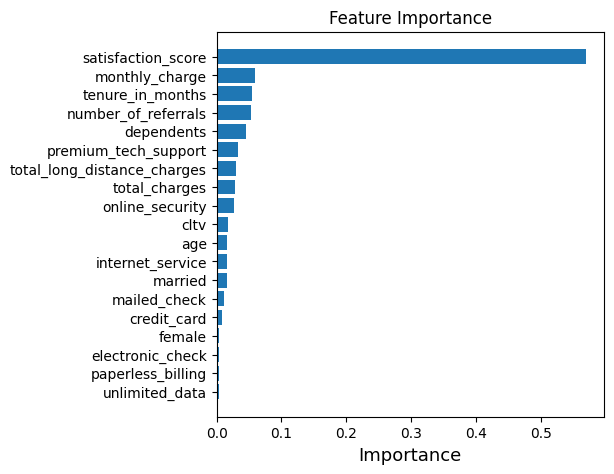

In [17]:
model = model = best_model['RF']
predicted_y = model.predict(X_test)
y_scores = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
result = abs(model.best_estimator_.feature_importances_)
sorted_idx = result.argsort()
model = 'RandomForestClassifier'

print("Random Forest Classification Report")
print('\n', classification_report(y_test, predicted_y))

metrics.loc['RF'] = [
                      str(round(accuracy_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(precision_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(recall_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(specificity_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(f1_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(mean_absolute_error(y_test, predicted_y), 3)),
                      str(round(log_loss(y_test, predicted_y), 3)),
                      str(round(roc_auc, 3)),
                      "70%-30%"]

print('\n')
print('\tEvaluation Metrics\n')
print(tabulate(metrics.tail(1), headers = 'keys', tablefmt = 'github'))
print('\n')

cm = confusion_matrix(y_test, predicted_y)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Churn", "Churn"])
cm_display.plot(colorbar = False)
plt.title('Confusion Matrix')
plt.xlabel("Predicted", fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel("Actual", fontsize = 15)
plt.yticks(fontsize = 12)
plt.show()

print('\n')
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.title('ROC Curve')
plt.xlabel("False Positive Rate", fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.yticks(fontsize = 12)
plt.text(0.7, 0.1, f'AUC = {roc_auc:.3f}', fontsize = 15)
plt.show()

print('\n')
fig = plt.figure(figsize = (5, 5))
plt.barh(range(X.shape[1]), result[sorted_idx])
plt.yticks(range(X.shape[1]), X_train.columns[sorted_idx], fontsize = 10)
plt.xticks(fontsize = 10)
plt.xlabel("Importance", fontsize = 13)
plt.title("Feature Importance")
plt.show()

**XG Boost**

XG Boost Classification Report

               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1548
           1       0.98      0.96      0.97      1547

    accuracy                           0.97      3095
   macro avg       0.97      0.97      0.97      3095
weighted avg       0.97      0.97      0.97      3095



	Evaluation Metrics

|     | Accuracy   | Precision   | Recall   | Specificity   | F1 Score   |   MAE |   Log Loss |   AUC | Train-Test   |
|-----|------------|-------------|----------|---------------|------------|-------|------------|-------|--------------|
| XGB | 96.77%     | 97.63%      | 95.86%   | 97.67%        | 96.74%     | 0.032 |      1.165 | 0.995 | 70%-30%      |




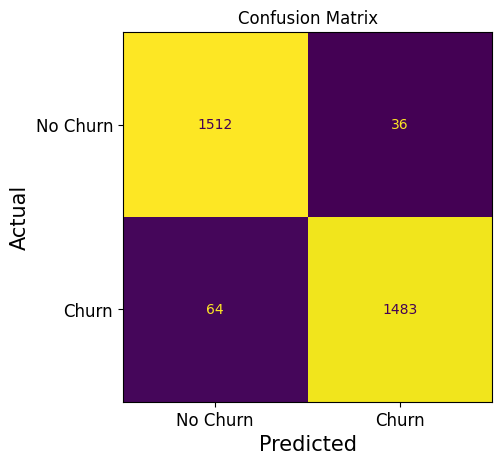

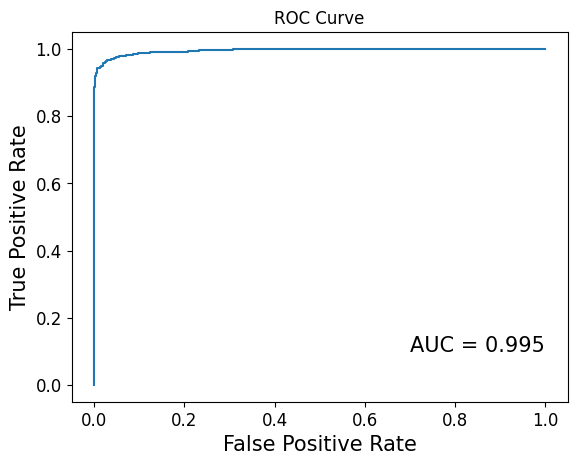

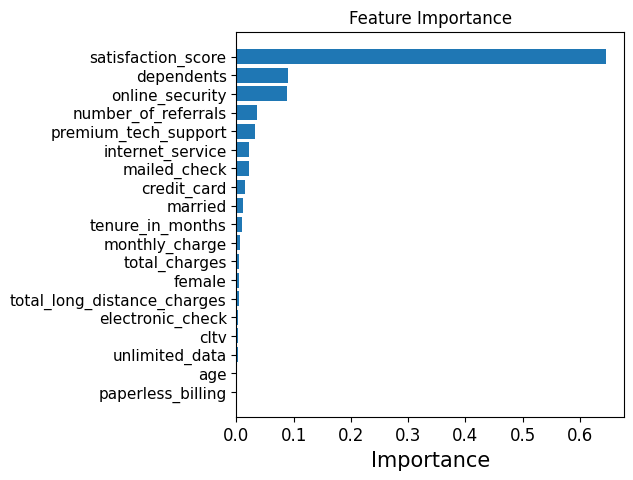

In [18]:
model = best_model['XGB']
predicted_y = model.predict(X_test)
y_scores = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
result = abs(model.best_estimator_.feature_importances_)
sorted_idx = result.argsort()
model = 'XGBClassifier'

print("XG Boost Classification Report")
print('\n', classification_report(y_test, predicted_y))
metrics.loc['XGB'] = [
                      str(round(accuracy_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(precision_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(recall_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(specificity_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(f1_score(y_test, predicted_y) * 100, 2))+"%",
                      str(round(mean_absolute_error(y_test, predicted_y), 3)),
                      str(round(log_loss(y_test, predicted_y), 3)),
                      str(round(roc_auc, 3)),
                      "70%-30%"]

print('\n')
print('\tEvaluation Metrics\n')
print(tabulate(metrics.tail(1), headers = 'keys', tablefmt = 'github'))
print('\n')

cm = confusion_matrix(y_test, predicted_y)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Churn", "Churn"])
cm_display.plot(colorbar = False)
plt.title('Confusion Matrix')
plt.xlabel("Predicted", fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel("Actual", fontsize = 15)
plt.yticks(fontsize = 12)
plt.show()

print('\n')
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
plt.title('ROC Curve')
plt.xlabel("False Positive Rate", fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.yticks(fontsize = 12)
plt.text(0.7, 0.1, f'AUC = {roc_auc:.3f}', fontsize = 15)
plt.show()

print('\n')
fig = plt.figure(figsize = (5, 5))
plt.barh(range(X.shape[1]), result[sorted_idx])
plt.yticks(range(X.shape[1]), X_train.columns[sorted_idx], fontsize = 11)
plt.xticks(fontsize = 12)
plt.xlabel("Importance", fontsize = 15)
plt.title("Feature Importance")
plt.show()

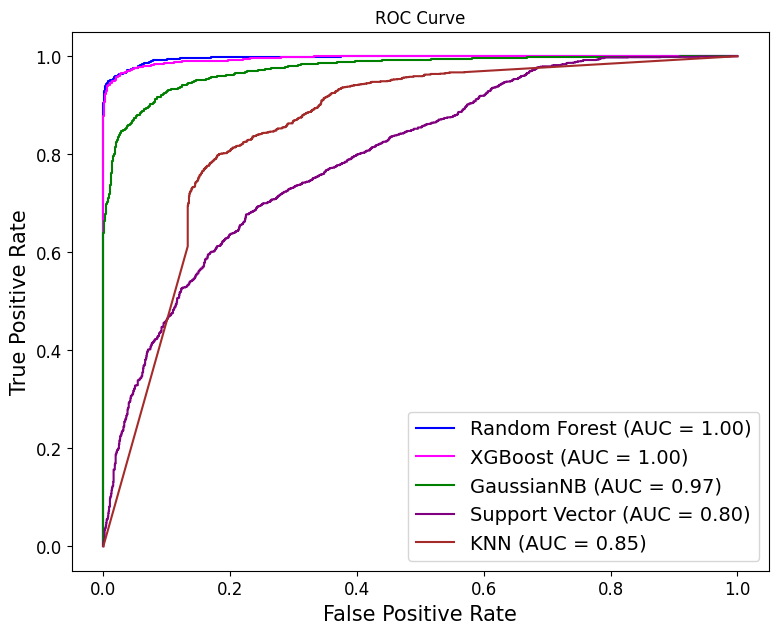

In [19]:
rf_prob = probs['RF']
# adaboost_prob = probs['ADAB']
xgb_prob = probs['XGB']
gnb_prob = probs['NB']
svc_prob = probs['SVC']
knn_prob = probs['KNN']

# calculate fpr and tpr for each model
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)
# adaboost_fpr, adaboost_tpr, _ = roc_curve(y_test, adaboost_prob)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_prob)
gnb_fpr, gnb_tpr, _ = roc_curve(y_test, gnb_prob)
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_prob)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_prob)

# plot the ROC curves using RocCurveDisplay
fig, ax = plt.subplots(figsize=(9, 7))

roc_display = RocCurveDisplay(fpr=rf_fpr, tpr=rf_tpr, roc_auc=auc(rf_fpr, rf_tpr), estimator_name='Random Forest')
roc_display.plot(ax=ax, color='blue')

# roc_display = RocCurveDisplay(fpr=adaboost_fpr, tpr=adaboost_tpr, roc_auc=auc(adaboost_fpr, adaboost_tpr), estimator_name='AdaBoost')
# roc_display.plot(ax=ax, color='red')

roc_display = RocCurveDisplay(fpr=xgb_fpr, tpr=xgb_tpr, roc_auc=auc(xgb_fpr, xgb_tpr), estimator_name='XGBoost')
roc_display.plot(ax=ax, color='magenta')

roc_display = RocCurveDisplay(fpr=gnb_fpr, tpr=gnb_tpr, roc_auc=auc(gnb_fpr, gnb_tpr), estimator_name='GaussianNB')
roc_display.plot(ax=ax, color='green')

roc_display = RocCurveDisplay(fpr=svc_fpr, tpr=svc_tpr, roc_auc=auc(svc_fpr, svc_tpr), estimator_name='Support Vector')
roc_display.plot(ax=ax, color='purple')

roc_display = RocCurveDisplay(fpr=knn_fpr, tpr=knn_tpr, roc_auc=auc(knn_fpr, knn_tpr), estimator_name='KNN')
roc_display.plot(ax=ax, color='brown')

plt.title('ROC Curve')
ax.legend(prop={'size':14}, loc='lower right')
plt.xlabel("False Positive Rate", fontsize = 15)
plt.xticks(fontsize = 12)
plt.ylabel("True Positive Rate", fontsize = 15)
plt.yticks(fontsize = 12)
plt.show()

In [20]:
metrics

,Accuracy,Precision,Recall,Specificity,F1 Score,MAE,Log Loss,AUC,Train-Test
KNN,77.87%,72.59%,89.53%,66.21%,80.17%,0.221,7.977,0.853,70%-30%
SVC,70.63%,68.23%,77.18%,64.08%,72.43%,0.294,10.586,0.796,70%-30%
NB,91.41%,90.62%,92.37%,90.44%,91.49%,0.086,3.098,0.974,70%-30%
RF,96.87%,98.46%,95.22%,98.51%,96.81%,0.031,1.13,0.997,70%-30%
XGB,96.77%,97.63%,95.86%,97.67%,96.74%,0.032,1.165,0.995,70%-30%


In [21]:
df = metrics.copy()
df.drop(['Train-Test'], axis = 1, inplace = True)
df.iloc[:, :5] = df.iloc[:, :5].apply(lambda x: x.str.slice(stop=-1))
df.iloc[:, :] = df.iloc[:, :].apply(lambda x: x.astype(float))
df.iloc[:, :5] = df.iloc[:, :5].apply(lambda x: x/100)
df = df[['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1 Score', 'AUC', 'MAE', 'Log Loss']]

<ipython-input-22-db7e280737e4>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(x_ticks, fontweight = 'bold', fontsize = 14)


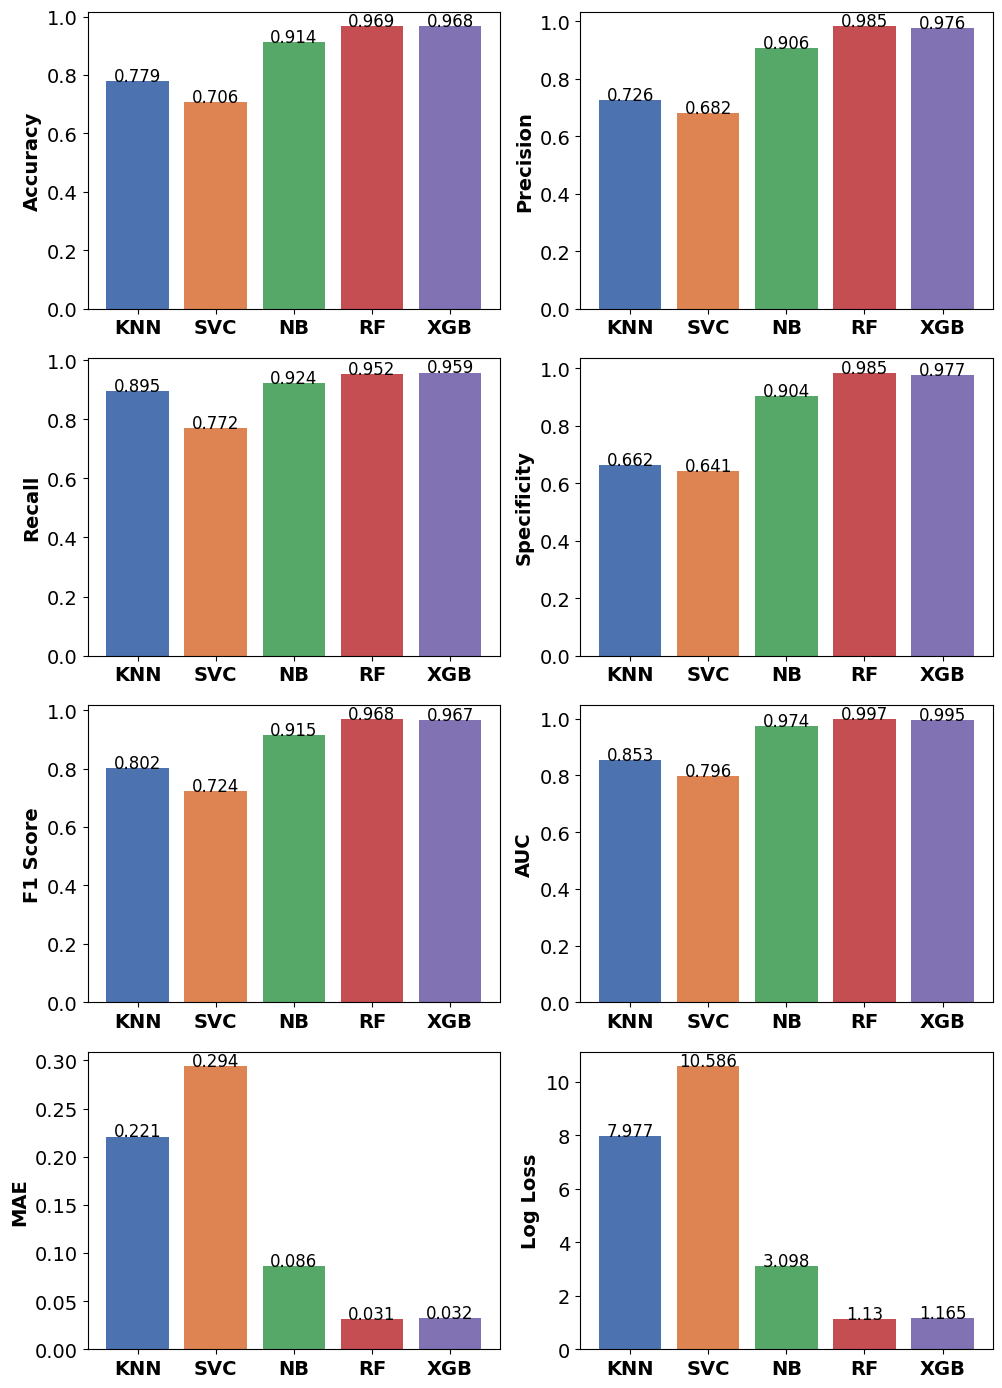

In [22]:
# create subplot with 3 rows and 2 columns
fig, ax = plt.subplots(4, 2, figsize=(10,14))

# flatten axes for easier iteration
ax = ax.flatten()

# set bar colors
colors = sns.color_palette('deep', len(df.columns))
x_ticks = list(metrics.index)

# iterate over columns and plot bar chart for each metric
for i, metric in enumerate(df.columns):
    ax[i].bar(df.index, df[metric], color=colors)
    ax[i].set_ylabel(metric, fontsize = 14, fontweight = 'bold')
    ax[i].tick_params(axis='both', labelsize=14)
    ax[i].set_xticklabels(x_ticks, fontweight = 'bold', fontsize = 14)
    ax[i].set_facecolor('white')
    
    # add value of bar at the center of each bar
    for j, v in enumerate(df[metric]):
        v = round(v, 3)
        ax[i].text(j, v, str(v), ha='center', fontsize = 12)

# adjust layout and show plot
plt.tight_layout()
plt.show()
